# The Quantum Approximate Optimisation Algorithm (QAOA)

The Quantum Approximate Optimisation Algorithm (QAOA) is a general technique that can be used to find the approximate solution to combinatorial optimisation problems. The QAOA is best suited to problems which find a specific bit string. 

In [1]:
from pennylane import qaoa
from matplotlib import pyplot as plt
import networkx as nx
from pennylane import numpy as np
import pennylane as qml

The quantum approximate optimization algorithm (QAOA) is a general technique that can be used to find approximate solutions to combinatorial optimization problems, in particular problems that can be cast as searching for an optimal bitstring. QAOA consists of the following steps:

1. Define a cost Hamiltonian $H_C$ such that its ground state encodes the solution to the optimization problem.
2. Define a mixer Hamiltonian $H_M$
3. Construct the circuits $e^{-i\gamma H_C}$ and $e^{-i\alpha H_M}$. We call these the cost and mixer layers, respectively.
4. Choose a parameter $n\geq 1$ and build the circuit cosisting of repeated layers of the cost and mixing layers,

$$
U = e^{-i\gamma_n H_C}e^{-i\alpha_n H_M}\dots e^{-i\gamma_1 H_C}e^{-i\alpha_1 H_M}
$$ 

5. Prepare an initial state, apply $U$ and use classical techniques to optimize the parameters.
6. After the circuit has been optimized, measurements of the output state reveal approximate solutions to the optimization problem.

In summary, the starting point of QAOA is the specification of cost and mixer Hamiltonians. We then use time evolution and layering to create a variational circuit and optimize its parameters. The algorithm concludes by sampling from the circuit to get an approximate solution to the optimization problem.

## Minimum Vertex Cover with QAOA

Here we will use the QAOA to find the minimum vertex cover of a graph: a collection of vertices such that each edge in the graph contains at least one of the vertices in the cover.

A vertex cover can be represented as a binary bit string. For example, for the 5 vertex graph below, the cover can be written as '01010'.

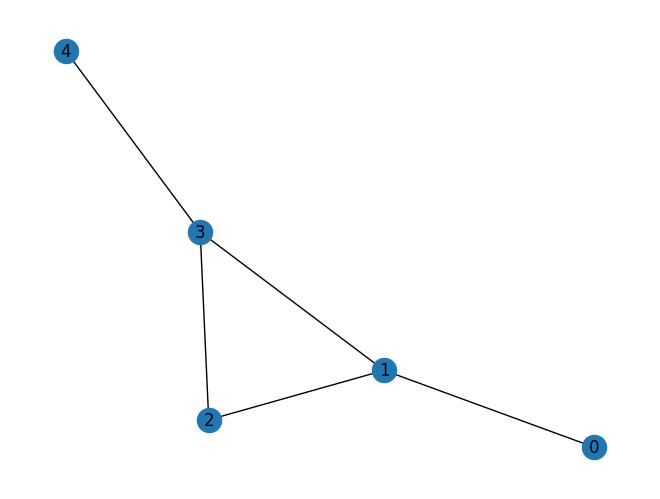

In [2]:
edges = [(0, 1), (1, 2), (1,3), (2,3), (3,4)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)

## Implementing the QAOA

Here we will implement the QAOA for a simple, four vertex graph and find the minimal cover.

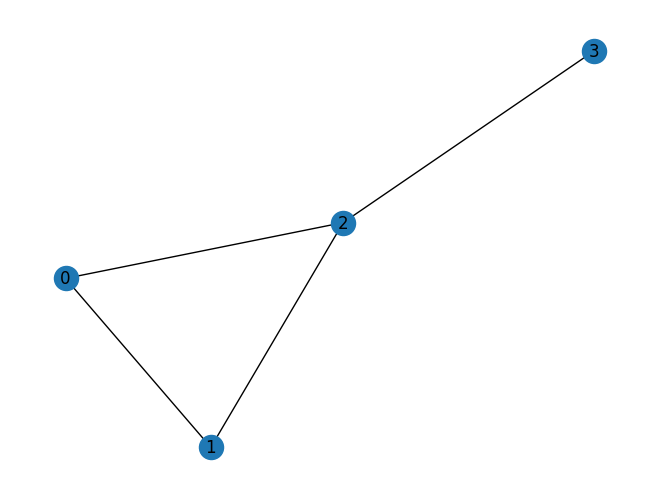

In [3]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)

There are two minimum covers in this graph: vertices 0 and 2, corresponding to 1010, and the vertices 1 and 2, corresponding to 0110. 

The PennyLane QAOA module has a collection of built-in optimization problems, including minimum vertex cover. For each problem, you can retrieve the cost Hamiltonian as well as a recommended mixer Hamiltonian.

In this example, the Hamiltonian has two ground states corresponding to the solutions to the minimum cover problem: $\vert 1010 \rangle$ and $\vert 0110\rangle$. The mixer Hamiltonian is the simple, non-commuting sum of Pauli-X operations on each node of the graph:

In [4]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian   (-0.25) [Z3]
+ (0.5) [Z0]
+ (0.5) [Z1]
+ (1.25) [Z2]
+ (0.75) [Z0 Z1]
+ (0.75) [Z0 Z2]
+ (0.75) [Z1 Z2]
+ (0.75) [Z2 Z3]
Mixer Hamiltonian   (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


A single layer of QAOA consists of time evolution under these Hamiltonians. 

The QAOA module allows you to build the cost and mixer layers directly using the functions `cost_layer()` and `mixer_layer()`, which take as input the respective Hamiltonian and variational parameters:

In [5]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

We are now ready to build the full variational circuit. The number of wires is equal to the number of vertices of the graph. We initialize the state to an even superposition over all basis states. For this example, we employ a circuit consisting of two QAOA layers:

In [6]:
wires = range(4)
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

Here we build the QNode, with our cost being the expectation value of the cost Hamiltonian. 

In [7]:
dev = qml.device("qulacs.simulator", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

DeviceError: Device does not exist. Make sure the required plugin is installed.

## Optimisation

We now perform the optimisation using a classical gradient descent.

In [8]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
params = np.array([[0.5 for i in range(depth)],[0.5 for i in range(depth)]], requires_grad=True)

In [9]:
for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[0.59806352 0.94198485]
 [0.52797281 0.85552845]]


## Optimal params

Now that we have calculated the optimal parameters, we can now reconstruct the probability landscape. We redefine the full QAOA circuit with the optimal parameters, but this time we return the probabilities of measuring each bit string.

In [10]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

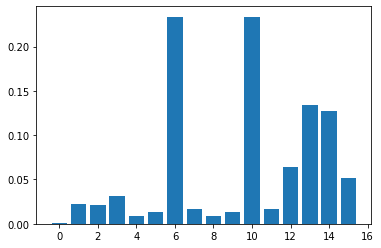

In [11]:
plt.bar(range(2 ** len(wires)), probs)
plt.show()

There state $\vert 6 \rangle$ corresponds to the $\vert 0110 \rangle$ state, and the $\vert 10 \rangle$ state corresponds to the $\vert 1010\rangle$ state, the solution to our minimum cover problem. 